In [77]:
%matplotlib inline
import segpy
from segpy.reader import create_reader
from segpy.writer import write_segy

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot
from PIL import Image

import os
import shutil

from collections import defaultdict, Counter
import joblib
import pickle

from scipy.stats import mode
from scipy.special import kl_div
from scipy.stats import entropy

from sklearn.preprocessing import MinMaxScaler

%run bp_smc_example.ipynb

[[95.36404963 95.36404963 95.36404963 ... 95.36404963 95.36404963
  95.36404963]
 [95.36404963 95.36404963 95.36404963 ... 95.36404963 95.36404963
  95.36404963]
 [95.36404963 95.36404963 95.36404963 ... 95.36404963 95.36404963
  95.36404963]
 ...
 [96.0172053  96.13570056 96.29280807 ... 90.33949478 90.84589263
  91.39890711]
 [95.61227848 95.7189809  95.91779872 ... 95.00570035 95.46676807
  95.84521876]
 [94.9763425  95.00548185 95.09194958 ... 98.66899498 98.8864824
  98.97616547]]


In [4]:
len(os.listdir('small_dataset'))

120

In [3]:
# split up stack and gather files into separate directories
for filename in os.listdir('small_dataset'):
    src = 'small_dataset/' + filename
    if 'gather' in filename:
        dst = 'gather/' + filename
        shutil.copy(src, dst)
    if 'stack' in filename:
        dst = 'stack/' + filename
        shutil.copy(src, dst)

In [5]:
print_segy_info('stack/img_12.stack.segy')

Filename:              stack/img_12.stack.segy
SEG Y revision:        SegYRevision.REVISION_0
Number of traces:      1058
Data format:           IBM 32 bit float
Dimensionality:        0

=== BEGIN TEXTUAL REEL HEADER ===
C01  BP syntheitc Date: 05/20/2019                                              
C02  image stack scenario with the following dimension                          
C03  axis  :         z         x         y                                      
C04  size  :       400      1058         1                                      
C05  origin:   0.00000   0.00000   0.00000                                      
C06  delta :  10.00000  10.00000  10.00000                                      
=== END TEXTUAL REEL HEADER ===


In [29]:
# make a dictionary of arrays for every realization in stack
stack_dict = {}
for filename in os.listdir('stack')[1:-1]:
    arr = np.zeros((1058, 400))

    with open(f'stack/{filename}', 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')

        for trace_index in segy_reader.trace_indexes():
            data = segy_reader.trace_samples(trace_index)
            for i in range(len(data)):
                arr[trace_index, i] = data[i]
    stack_dict[filename] = arr

In [30]:
# make a dictionary of arrays for every realization in stack
gather_dict = {}
for filename in os.listdir('gather')[1:-1]:
    arr = np.zeros((1058, 39, 400))
    with open(f'gather/{filename}', 'rb') as segy_in_file:
        segy_reader = create_reader(segy_in_file, endian='>')

        count = 0
        for trace_index in segy_reader.trace_indexes():
            data = segy_reader.trace_samples(trace_index)
            for i in range(len(data)):
                arr[int(trace_index / 39), trace_index % 39, i] = data[i]
    gather_dict[filename] = arr

KeyboardInterrupt: 

In [6]:
# load the two dictionaries into the directory to use later
# joblib.dump(stack_dict, 'stack_dict')
stack_dict = joblib.load(open('stack_dict', 'rb'))

# joblib.dump(gather_dict, 'gather_dict')
# gather_dict = joblib.load(open('gather_dict', 'rb'))

In [42]:
for key in stack_dict.keys():
    print(key)
    print(stack_dict[key].shape)
print(len(stack_dict))

# there 1058 instances of 400 elements arrays

img_1.stack.segy
(1058, 400)
img_10.stack.segy
(1058, 400)
img_11.stack.segy
(1058, 400)
img_12.stack.segy
(1058, 400)
img_13.stack.segy
(1058, 400)
img_14.stack.segy
(1058, 400)
img_15.stack.segy
(1058, 400)
img_16.stack.segy
(1058, 400)
img_17.stack.segy
(1058, 400)
img_18.stack.segy
(1058, 400)
img_19.stack.segy
(1058, 400)
img_2.stack.segy
(1058, 400)
img_20.stack.segy
(1058, 400)
img_21.stack.segy
(1058, 400)
img_22.stack.segy
(1058, 400)
img_23.stack.segy
(1058, 400)
img_24.stack.segy
(1058, 400)
img_25.stack.segy
(1058, 400)
img_26.stack.segy
(1058, 400)
img_27.stack.segy
(1058, 400)
img_28.stack.segy
(1058, 400)
img_29.stack.segy
(1058, 400)
img_3.stack.segy
(1058, 400)
img_30.stack.segy
(1058, 400)
img_31.stack.segy
(1058, 400)
img_32.stack.segy
(1058, 400)
img_33.stack.segy
(1058, 400)
img_34.stack.segy
(1058, 400)
img_35.stack.segy
(1058, 400)
img_36.stack.segy
(1058, 400)
img_37.stack.segy
(1058, 400)
img_38.stack.segy
(1058, 400)
img_39.stack.segy
(1058, 400)
img_4.stack.s

In [8]:
# turn dictionary into pixel arrays (1058 x 400)
stack_arr = {}

for key in stack_dict.keys():
    arr = stack_dict[key]
    arr = arr.transpose()
    min_arr = arr.min()
    max_arr = arr.max()
    arr = (arr - min_arr) / (max_arr - min_arr)
    arr = arr * 255
    stack_arr[key] = arr


In [118]:
def mode_func(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m], 

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [131]:
# function computes the uncertainty image of all the stack segy files
cnt = Counter()

def uncertainty_image(stack_dict):
    images = []
    kl_arrs = []
    
    kl_arr = np.zeros((1058, 400))
    big_arr = np.zeros((len(stack_dict), 1058, 400))
    
    index = 0
    for key in stack_dict.keys():
        arr = stack_dict[key]
        big_arr[index, :, :] = arr
        index += 1  

    for i in range(1058):
        for j in range(400):

            # create bins corresponding to the range of each length 400 array
            arr = big_arr[:, i, j]
            bins = np.linspace(arr.min(), arr.max(), num=10)
            binned_arr = np.digitize(arr, bins)

            # count up the frequency of the bins that occupied 
            cnt = np.zeros(10)
            for val in binned_arr:
                cnt[val-1] += 1

            freq_arr = cnt
            max_val = max(freq_arr)

            # one hot encode a length 10 vector to give a 1 to the bin with the most number of values in it
            onehot_arr = [1e-9 if x != max_val else 1.0 - (1e-9 * (len(freq_arr) - 1)) for x in freq_arr]

            freq_arr = np.array(freq_arr) / len(stack_dict)
#             print(freq_arr)

            # compute kl between one hot vector and freq_arr which is a likelihood probability vector of the bins
            kl_score = kl_divergence(freq_arr, onehot_arr)

            # store the kl_score as a matrix filled with that value
            kl_arr[i, j] = kl_score

    score_arr = kl_arr

    score_arr = score_arr.transpose()
    min_arr = score_arr.min()
    max_arr = score_arr.max()
    score_arr = (score_arr - min_arr) / (max_arr - min_arr)
    score_arr = score_arr * 255

    kl_arrs.append(score_arr)

    im = Image.fromarray(score_arr)
    im = im.convert('RGB')
    images.append(im)

    return kl_arr, images

In [132]:
kl_arr, images = uncertainty_image(stack_dict)

C:\Users\212807124\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\212807124\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


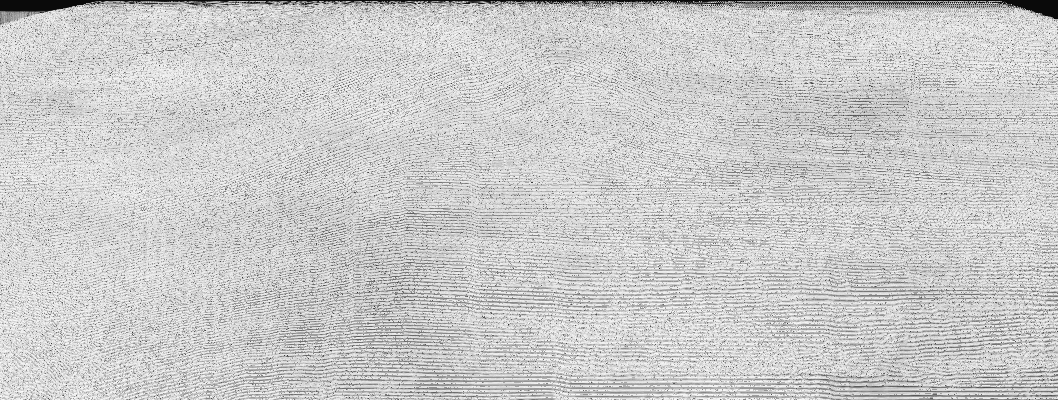

In [127]:
images[0]

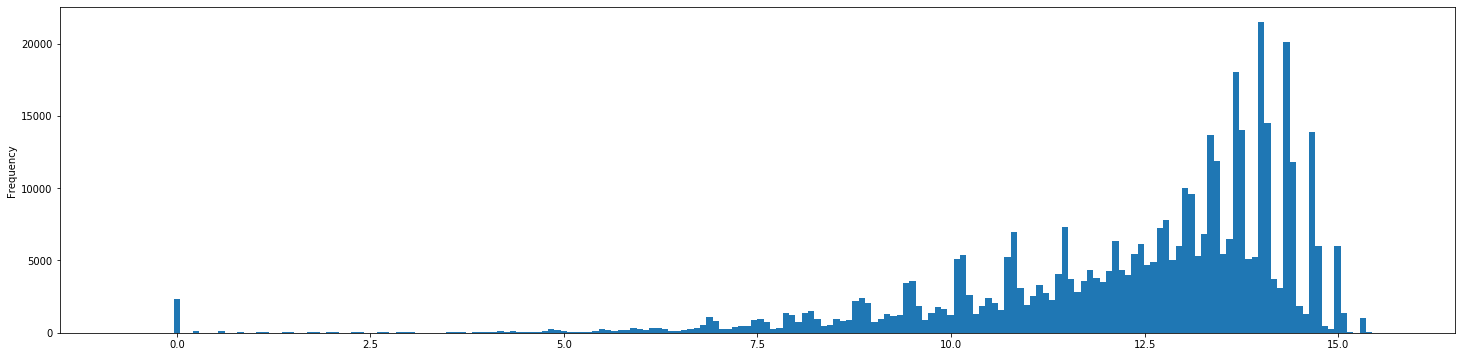

In [128]:
pd.Series(kl_arr.flatten()).plot(kind='hist', figsize=(25, 6), bins=200);

In [90]:
cnt = np.zeros(10)
cnt

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])